In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.somsc import somsc
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.samples.definitions import FCPS_SAMPLES, SIMPLE_SAMPLES

# Clustering

In [2]:
customer_indicators = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

### Pre-processing

In [3]:
dataset = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
dataset['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
dataset['Recency'] = customer_indicators[['Recency']]
dataset['CustomerID'] = customer_indicators[['CustomerID']]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset[['Delta', 'Recency', 'RMonetary']].values)

## K-means

In [4]:
sse = []
silhouette = []
kmax = 19
for k in range(2, kmax):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(data_scaled, kmeans.labels_))

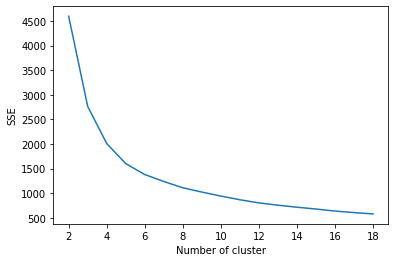

In [5]:
# Elbow curve.
ax = plt.plot(range(2, kmax), sse)
plt.xlabel('Number of cluster')
plt.ylabel('SSE')
plt.show()

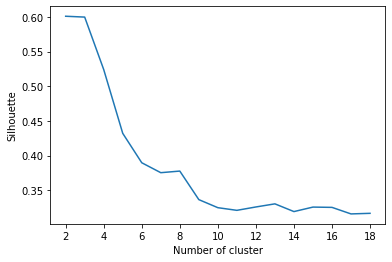

In [6]:
# Silhouette score.
ax = plt.plot(range(2, kmax), silhouette)
plt.xlabel('Number of cluster')
plt.ylabel('Silhouette')
plt.show()

SSE: 
1379.011749519615
Silhouette: 
0.38934441515975593


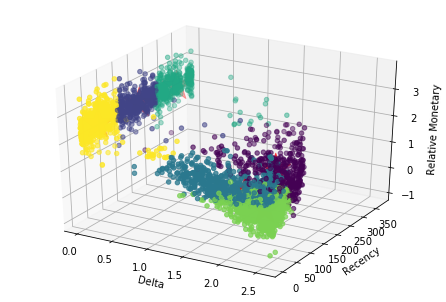

In [7]:
# kmeans best choice parameters

k_best = 6
kmeans_best = KMeans(n_clusters=k_best, n_init=10, max_iter=100)
kmeans_best.fit(data_scaled)
print('SSE: ') 
print(kmeans_best.inertia_)
print('Silhouette: ') 
print(silhouette_score(data_scaled, kmeans_best.labels_))

centers = scaler.inverse_transform(kmeans_best.cluster_centers_)
centroids_x = centers[:,0]
centroids_y = centers[:,1]
centroids_z = centers[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=kmeans_best.labels_)
ax.scatter(centroids_x,centroids_y,centroids_z,s=1000, marker='*', c='r')
ax.set_xlabel('Delta')
ax.set_ylabel('Recency')
ax.set_zlabel('Relative Monetary')
plt.show()

### Post-processing

In [8]:
# create column containing cluster label
dataset['Behavior'] = kmeans_best.labels_
dataset.head()

,RMonetary,Delta,Recency,CustomerID,Behavior
0,1.071,2.563,2,12347,2
1,0.706,2.452,75,12348,4
2,3.164,0.000,19,12349,5
3,2.469,0.000,310,12350,3
4,0.725,2.417,36,12352,4


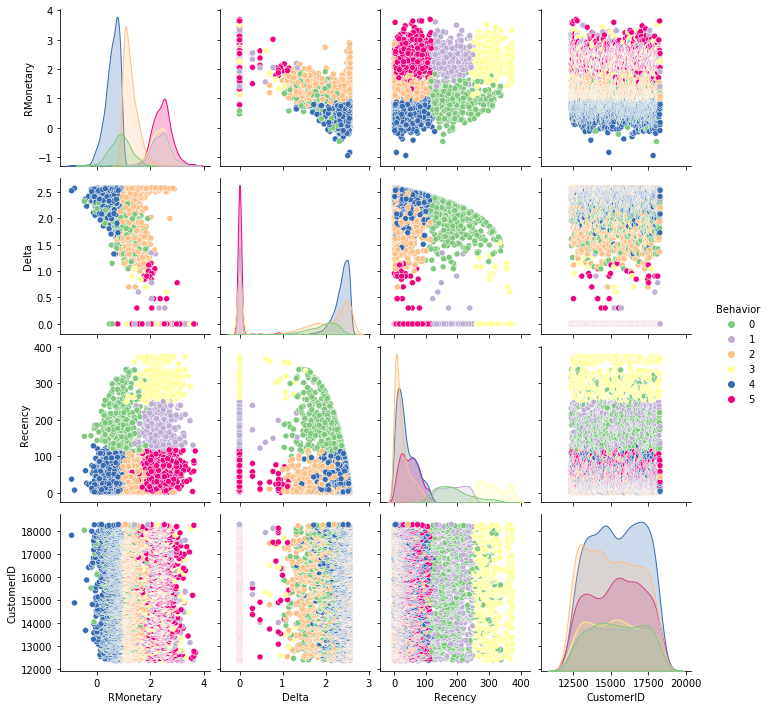

In [9]:
sns.pairplot(data=dataset, hue="Behavior", palette="Accent")
plt.show()

In [10]:
clusters = list()
for i in range(0, 6):
    clusters.append(dataset[dataset['Behavior'] == i])

In [11]:
for i in range(0, len(clusters)):
    print(clusters[i].describe())

        RMonetary       Delta     Recency    CustomerID  Behavior
count  414.000000  414.000000  414.000000    414.000000     414.0
mean     0.875505    1.938353  187.181159  15392.033816       0.0
std      0.378628    0.329150   55.223723   1709.632631       0.0
min     -0.473000    0.000000   99.000000  12377.000000       0.0
25%      0.613750    1.740000  144.250000  13957.000000       0.0
50%      0.876500    2.013000  177.500000  15380.000000       0.0
75%      1.127000    2.189500  217.000000  16895.000000       0.0
max      1.903000    2.401000  338.000000  18260.000000       0.0
        RMonetary       Delta     Recency    CustomerID  Behavior
count  392.000000  392.000000  392.000000    392.000000     392.0
mean     2.386260    0.015372  188.038265  15366.431122       1.0
std      0.348669    0.120186   38.518485   1742.892427       0.0
min      1.176000    0.000000  119.000000  12353.000000       1.0
25%      2.150000    0.000000  155.750000  13831.250000       1.0
50%      2

## DBSCAN

In [12]:
dist = pdist(data_scaled, 'euclidean')
dist = squareform(dist)

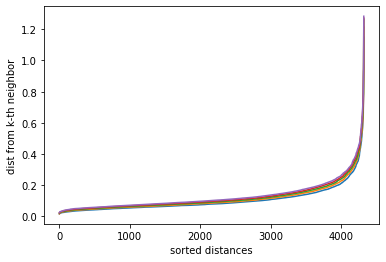

In [13]:
plt.ylabel('dist from k-th neighbor')
plt.xlabel('sorted distances')
plt.tick_params(axis='both')
for k in range(5, 10):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))

In [14]:
# Random parameters selection
density = DBSCAN(eps=0.2, min_samples=5).fit(data_scaled)
labels = density.labels_
labels

array([0, 0, 1, ..., 0, 0, 0])

In [15]:
dbscan_df = dataset.copy()
del dbscan_df['Behavior']
dbscan_df["label"] = labels

/home/alessio/.local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/alessio/.local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


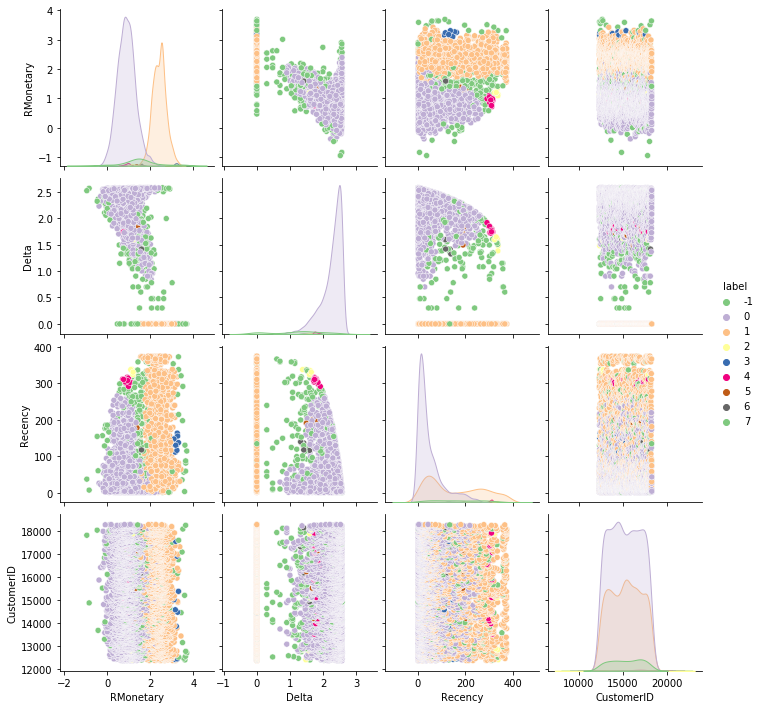

In [16]:
sns.pairplot(data = dbscan_df, hue = "label", palette = "Accent")
plt.show()

## Grid search

In [17]:
eps_to_test = [round(eps, 1) for eps in np.arange(0.1, 1, 0.1)]
min_samples_to_test = range(5, 50, 5)

In [18]:
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting
    dbscan_model_ = DBSCAN(eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log
    #print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [19]:
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test), len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test), len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [20]:
iter_ = 0

#print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
#print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Computing metrics
        noise_metric, cluster_metric = get_metrics(eps, min_samples, data_scaled, iter_)
        
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

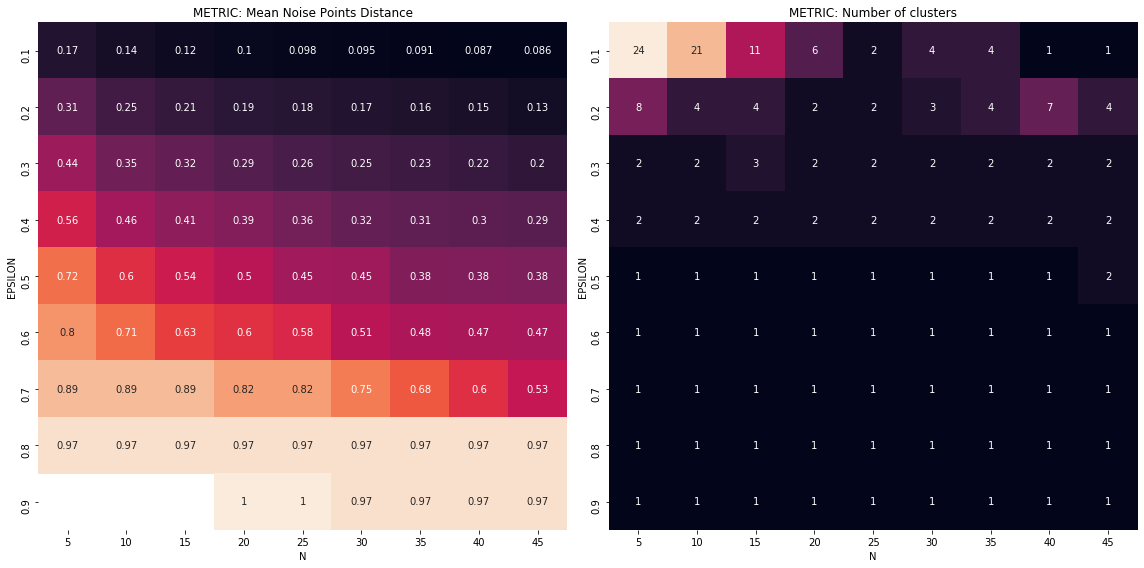

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

In [22]:
# Best parameters
density = DBSCAN(eps=0.4, min_samples=5).fit(data_scaled)
labels = density.labels_
print(metrics.silhouette_score(data_scaled, labels))

results = np.unique(labels, return_counts=True)
print(f"Clusters labels: {results[0]}")
print(f"Elements per cluster: {results[1]}")

0.502074955044931
Clusters labels: [-1  0  1]
Elements per cluster: [  21 2745 1556]


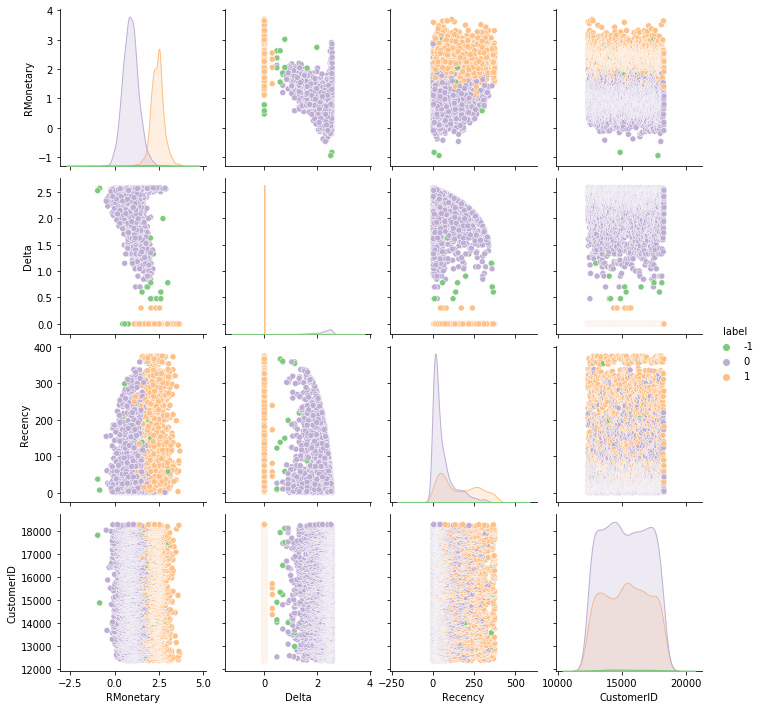

In [23]:
dbscan_df["label"] = labels
sns.pairplot(data=dbscan_df, hue="label", palette="Accent")
plt.show()

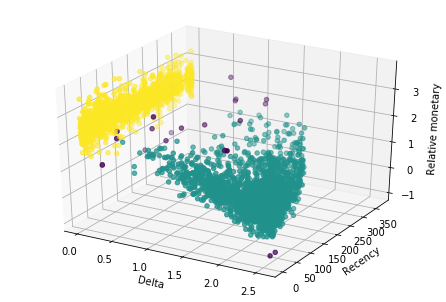

In [24]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=density.labels_)
ax.set_xlabel('Delta')
ax.set_ylabel('Recency')
ax.set_zlabel('Relative monetary')
plt.show()

# Hierarchical

In [25]:
dataset = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
dataset['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
dataset['Recency'] = customer_indicators[['Recency']]#.apply(np.log10, axis=1).round(3)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset[['Delta', 'Recency', 'RMonetary']].values)

dataframe_scaled = pd.DataFrame(data_scaled, columns=['Delta', 'Recency', 'RMonetary'])
dataframe_scaled

,Delta,Recency,RMonetary
0,1.051627,-0.905630,-0.449486
1,0.950599,-0.176149,-0.887405
2,-1.281121,-0.735751,2.061651
3,-1.281121,2.172178,1.227805
4,0.918744,-0.565872,-0.864610
...,...,...,...
4317,-1.281121,1.852406,0.973452
4318,-1.281121,0.883096,0.554729
4319,0.608378,-0.845673,-1.524488
4320,1.016131,-0.885644,-0.779425


0.5830440476494503


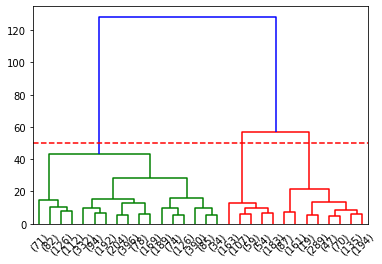

In [26]:
threshold = 50
data_dist = pdist(data_scaled, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')
print(metrics.silhouette_score(dataframe_scaled, clusters))

-0.10933764663803848


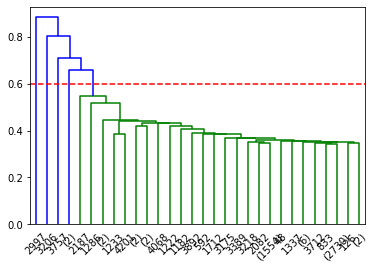

In [27]:
threshold = 0.6
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')
print(metrics.silhouette_score(dataframe_scaled, clusters))

0.38150720689013706


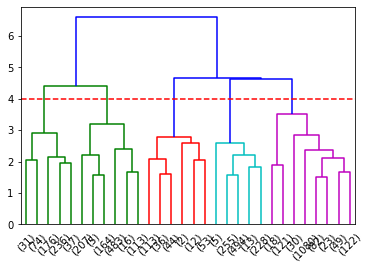

In [28]:
threshold = 4
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')
print(metrics.silhouette_score(dataframe_scaled, clusters))

0.43121753715844485


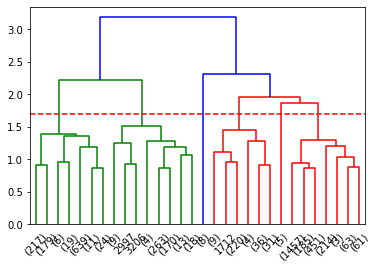

In [29]:
threshold = 1.7
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=threshold, color='r', linestyle='--')
clusters = fcluster(data_link, threshold,  criterion='distance')
print(metrics.silhouette_score(dataframe_scaled, clusters))

Text(0, 0.5, 'Recency')

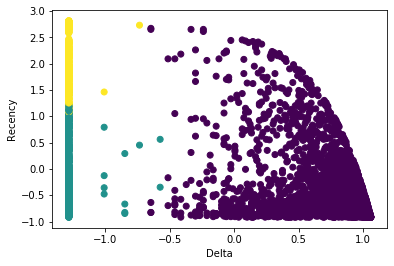

In [30]:
agg_ward = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
agg_ward.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['Delta'], dataframe_scaled['Recency'], c=agg_ward.labels_)
plt.xlabel('Delta')
plt.ylabel('Recency')

Text(0, 0.5, 'Recency')

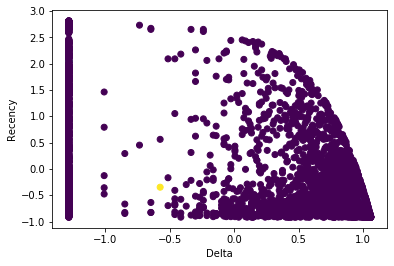

In [31]:
agg_single = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')  
agg_single.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['Delta'], dataframe_scaled['Recency'], c=agg_single.labels_) 
plt.xlabel('Delta')
plt.ylabel('Recency')

Text(0, 0.5, 'Recency')

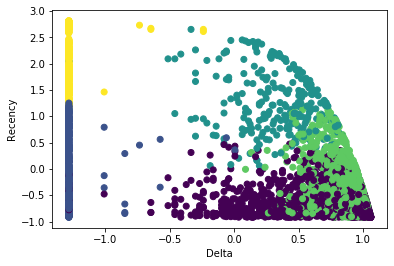

In [32]:
agg_comp = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')  
agg_comp.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['Delta'], dataframe_scaled['Recency'], c=agg_comp.labels_) 
plt.xlabel('Delta')
plt.ylabel('Recency')

Text(0, 0.5, 'Recency')

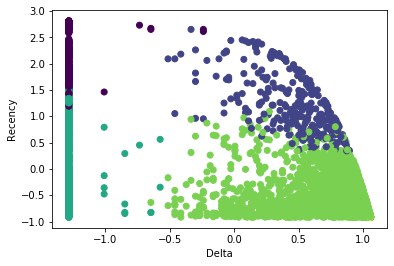

In [33]:
agg_avg = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='average')  
agg_avg.fit_predict(data_scaled)
plt.scatter(dataframe_scaled['Delta'], dataframe_scaled['Recency'], c=agg_avg.labels_) 
plt.xlabel('Delta')
plt.ylabel('Recency')

## Comparisons

In [34]:
labels_kmeans = kmeans.labels_
labels_comp = agg_comp.labels_
labels_avg = agg_avg.labels_
labels_ward = agg_ward.labels_
labels_single = agg_single.labels_

kmean_sil = metrics.silhouette_score(dataframe_scaled, labels_kmeans)
ward_sil = metrics.silhouette_score(dataframe_scaled, labels_ward) 
avg_sil = metrics.silhouette_score(dataframe_scaled,labels_avg)  
comp_sil = metrics.silhouette_score(dataframe_scaled, labels_comp)
single_sil = metrics.silhouette_score(dataframe_scaled, labels_single)

print(kmean_sil)
print(ward_sil)
print(avg_sil)
print(comp_sil)
print(single_sil)

0.3166027106027635
0.5830440476494503
0.43121753715844485
0.38150720689013706
-0.10933764663803848


# Extra: X-Means

In [35]:
# initial centers - optional parameter, if it is None, then random centers will be used by the algorithm.
# avoid random initial centers and initialize them using K-Means++ method

initial_centers = kmeans_plusplus_initializer(data_scaled, 2).initialize();
xmeans_instance = xmeans(data_scaled, initial_centers, criterion=splitting_type.BAYESIAN_INFORMATION_CRITERION, ccore=True);

### Bayesian Information Criterion

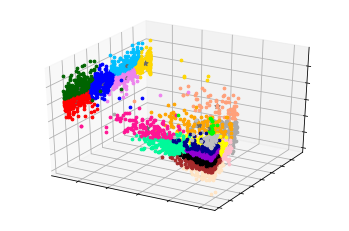

In [36]:
initial_centers = kmeans_plusplus_initializer(data_scaled, 2).initialize();
xmeans_instance = xmeans(data_scaled, initial_centers, criterion=splitting_type.BAYESIAN_INFORMATION_CRITERION, ccore=True);

# run cluster analysis
xmeans_instance.process();

# obtain results of clustering
clusters = xmeans_instance.get_clusters();
centers = xmeans_instance.get_centers()

# display allocated clusters
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, data_scaled);
visualizer.append_cluster(centers, None, marker = '*');
visualizer.show();

### Minimum Noiseless Description Length

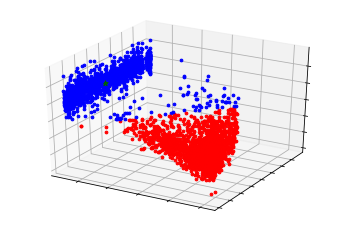

In [37]:
initial_centers = kmeans_plusplus_initializer(data_scaled, 2).initialize();
xmeans_instance = xmeans(data_scaled, initial_centers, criterion=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH, ccore=True);
# run cluster analysis
xmeans_instance.process();

# obtain results of clustering
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
# display allocated clusters
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, data_scaled);
visualizer.append_cluster(centers, None, marker = '*');
visualizer.show();

# SOM-SC

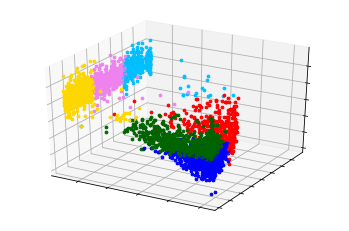

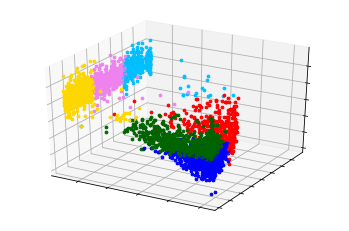

In [38]:
# Create instance of SOM-SC algorithm to allocated six clusters
somsc_instance = somsc(data_scaled, 6)

# Run cluster analysis and obtain results
somsc_instance.process()
clusters = somsc_instance.get_clusters()

# Visualize clustering results.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, data_scaled)
visualizer.show()

# Preparation for classification

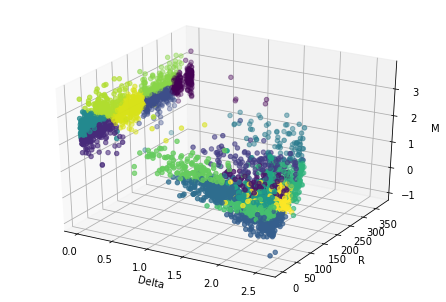

In [39]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=kmeans.labels_)
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')
plt.show()

The customers with delta = 0 (the delta axis is log-transformed) have observations for only one day, so we can't derive an effective classification among high, medium or low spending, and we remove them for the next task.

In [40]:
low = dataset[(dataset['Delta'] == 0) & (dataset['Recency'] > 60)]
dataset = dataset[dataset['Delta'] != 0]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset[['Delta', 'Recency', 'RMonetary']].values)

In [41]:
sse = []
silhouette = []
kmax = 6
for k in range(2, kmax):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(data_scaled, kmeans.labels_))
dataset['Behavior'] = kmeans.labels_

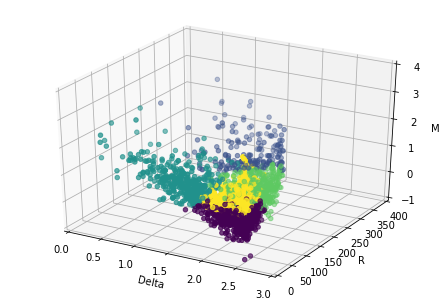

In [42]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dataset['Delta'], dataset['Recency'], dataset['RMonetary'], c=kmeans.labels_)
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')

ax.set_xlim3d(0, 3)
ax.set_ylim3d(0, 400)
ax.set_zlim3d(-1, 4)

plt.show()

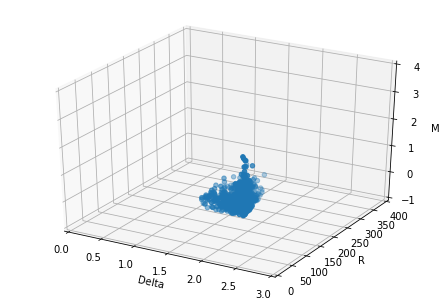

In [43]:
x = dataset[dataset['Behavior'] == 4]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x['Delta'], x['Recency'], x['RMonetary'])
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')

ax.set_xlim3d(0, 3)
ax.set_ylim3d(0, 400)
ax.set_zlim3d(-1, 4)

plt.show()

In [44]:
def Score(x):
    if x == 1:
        return 'High'
    elif x == 3:
        return 'Low'
    else:
        return 'Medium'

In [45]:
dataset['Label'] = dataset['Behavior'].apply(Score)
del dataset['Behavior']
dataset.head()

,RMonetary,Delta,Recency,Label
0,1.071,2.563,2,Medium
1,0.706,2.452,75,Medium
4,0.725,2.417,36,Medium
8,0.914,2.481,23,Medium
10,0.791,2.176,2,Medium


In [46]:
low['Label'] = 'Low'

In [47]:
result = dataset.append(low)

In [48]:
#result.to_csv('datasets/clustering_labels.csv')